### Dataset of all classes

In [11]:
import os
import torchvision.datasets as datasets
from torchvision import transforms
from PIL import Image

# Define the paths for the output folders
output_root = "Ayana_Bharti"
mnist_all_path = os.path.join(output_root, "train_mnist_all")

# Create the output folders
os.makedirs(mnist_all_path, exist_ok=True)

# Load the MNIST dataset
mnist_dataset = datasets.MNIST(root="./", download=True, train=True, transform=transforms.ToTensor())

# Organize the dataset into the specified folders
for image, label in mnist_dataset:
    if label in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        folder = os.path.join(mnist_all_path, f"train_image{label}_folder")
    else:
        continue  # Skip other labels

    os.makedirs(folder, exist_ok=True)
    image = transforms.ToPILImage()(image)  # Convert the image to PIL format
    image.save(os.path.join(folder, f"{label}_{len(os.listdir(folder))}.png"), "PNG")

print("MNIST dataset organized as requested.")

MNIST dataset organized as requested.


## dataset division in 2 training and one testing set, this is iid dataset

In [12]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from collections import defaultdict
import random

# Define your data transforms
data_transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Load the entire dataset
dataset_all = ImageFolder('Ayana_Bharti/train_mnist_all', transform=data_transform)

# Organize dataset indices by class
class_indices = defaultdict(list)
for idx, (_, label) in enumerate(dataset_all):
    class_indices[label].append(idx)

# Shuffle indices within each class
for label in class_indices:
    random.shuffle(class_indices[label])

# Split indices for each class into training and testing sets
train_indices_client1 = []
train_indices_client2 = []
test_indices = []

for label, indices in class_indices.items():
    total_count = len(indices)
    train_count = total_count * 2 // 3  # Reserve 2/3 of data for training
    client1_count = train_count // 2   # Split training data equally between clients
    client2_count = train_count - client1_count
    test_count = total_count - train_count

    train_indices_client1.extend(indices[:client1_count])
    train_indices_client2.extend(indices[client1_count:client1_count + client2_count])
    test_indices.extend(indices[client1_count + client2_count:])

# Create Subsets for each client and test set
subset_client1 = Subset(dataset_all, train_indices_client1)
subset_client2 = Subset(dataset_all, train_indices_client2)
subset_test = Subset(dataset_all, test_indices)

# Create DataLoaders for clients and test set
batch_size = 64
loader_client1 = DataLoader(subset_client1, batch_size=batch_size, shuffle=True)
loader_client2 = DataLoader(subset_client2, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(subset_test, batch_size=batch_size, shuffle=True)

print(f"Client 1 training samples: {len(subset_client1)}")
print(f"Client 2 training samples: {len(subset_client2)}")
print(f"Test samples: {len(subset_test)}")


Client 1 training samples: 69201
Client 2 training samples: 69206
Test samples: 69207


#### Maps 8 features to 3 output classes.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os

In [14]:
class MLP(nn.Module):
    def __init__(self, input_size=14 * 14, hidden_sizes=(128, 64), output_size=10, dropout=0.2):
        """
        Parameters:
        - input_size: Size of the flattened input.
        - hidden_sizes: Tuple defining the sizes of the hidden layers.
        - output_size: Number of output classes (default is 10).
        - dropout: Dropout probability (default is 0.2).
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output logits (not softmax applied here)
        return x


In [15]:
def train_model(model, dataloader, num_epochs, learning_rate, device='cpu'):
    """
    Trains a PyTorch model using the provided dataloader, loss function, and optimizer.

    Parameters:
    - model: The neural network to train.
    - dataloader: DataLoader containing the training data.
    - num_epochs: Number of epochs to train the model.
    - learning_rate: Learning rate for the optimizer.
    - device: The device to train on ('cpu' or 'cuda').

    Returns:
    - model: The trained model.
    """
    model.to(device)  # Move the model to the specified device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0
        correct = 0
        total_samples = 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the same device as the model

            optimizer.zero_grad()  # Clear the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update the weights

            total_loss += loss.item()  # Sum up the batch loss
            _, predicted = torch.max(outputs, 1)  # Get predictions
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Update total samples

        # Compute average loss and accuracy
        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total_samples * 100
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    print("Training complete.")
    return model


In [16]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Suggestion 1: Track Individual Client Performance
# Function to evaluate local models on their respective datasets
def evaluate_local_models(client_models, client_dataloaders, criterion):
    client_performance = {}

    for client_id, model in client_models.items():
        model.eval()
        correct = 0
        total = 0
        loss = 0

        for data, labels in client_dataloaders[client_id]:
            outputs = model(data)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        accuracy = correct / total
        avg_loss = loss / len(client_dataloaders[client_id])
        client_performance[client_id] = {"accuracy": accuracy, "loss": avg_loss}

    return client_performance

# Example usage:
# client_performance = evaluate_local_models(client_models, client_dataloaders, criterion)
# print(client_performance)

# Suggestion 2: Analyze Dataset Diversity
# Function to visualize the distribution of datasets across clients
def analyze_dataset_diversity(client_dataloaders):
    """
    Analyze the label distribution across client datasets.
    Args:
        client_dataloaders (dict): Dictionary of client_id -> DataLoader.
    """
    label_distribution = defaultdict(list)

    for client_id, dataloader in client_dataloaders.items():
        labels = []
        for _, label in dataloader:
            labels.extend(label.numpy())  # Collect all labels

        unique, counts = np.unique(labels, return_counts=True)
        for u, c in zip(unique, counts):
            label_distribution[u].append((client_id, c))

    # Visualize distribution
    for label, distributions in label_distribution.items():
        clients, counts = zip(*distributions)
        plt.bar(clients, counts, label=f"Label {label}")

    plt.xlabel("Clients")
    plt.ylabel("Count")
    plt.title("Dataset Diversity across Clients")
    plt.legend()
    plt.show()



# Example usage:
# analyze_dataset_diversity(client_datasets)

# Suggestion 3: Inspect Aggregation Method (FedAvg)



# def federated_average(models, weights):
#     """
#     Aggregates client models using weighted averaging.
#     Args:
#         models: Dictionary of client_id -> model_state_dict
#         weights: List of dataset sizes for each client

#     Returns:
#         Aggregated model state_dict
#     """
#     aggregated_model = {key: 0 for key in models[next(iter(models))].keys()}
#     total_weight = sum(weights)

#     for client_id, model_state in models.items():
#         weight = weights[client_id] / total_weight
#         for key in aggregated_model.keys():
#             aggregated_model[key] += model_state[key] * weight

#     return aggregated_model

# Example usage:
# aggregated_model_state = federated_average(client_models, client_weights)
# global_model.load_state_dict(aggregated_model_state)

# Track how weights are being applied
# print("Client weights:", client_weights)

# Ensure all methods are executed sequentially within your FL framework for analysis.


In [17]:
# def server_averaging(*local_models, device='cpu'):
#     """
#     Averages the parameters of multiple local models to create a global model.

#     Parameters:
#     - *local_models: Variable number of trained local models (e.g., model_all1, model_all2).
#     - device: The device ('cpu' or 'cuda') to perform computations on.

#     Returns:
#     - server_model: The globally averaged model.
#     """
#     if len(local_models) < 2:
#         raise ValueError("At least two models are required for averaging.")
    
#     # Initialize the global model
#     server_model = MLP().to(device)
#     averaged_params = {}

#     # Extract parameters and move to the specified device
#     local_state_dicts = [model.state_dict() for model in local_models]

#     # Parameter Averaging
#     for key in local_state_dicts[0]:  # Iterate over the parameter keys
#         averaged_params[key] = sum(local_state_dict[key] for local_state_dict in local_state_dicts) / len(local_state_dicts)

#     # Load averaged parameters into the server model
#     server_model.load_state_dict(averaged_params)

#     # Save the server model parameters to a file
#     os.makedirs('textfiles', exist_ok=True)  # Ensure the directory exists
#     torch.save(server_model.state_dict(), 'textfiles/serveriid_all.txt')

#     return server_model



def server_averaging(*local_models, device='cpu'):
    """
    Averages the parameters of multiple local models to create a global model.

    Parameters:
    - *local_models: Variable number of trained local models (e.g., model_all1, model_all2).
    - device: The device ('cpu' or 'cuda') to perform computations on.

    Returns:
    - server_model: The globally averaged model.
    """
    if len(local_models) < 2:
        raise ValueError("At least two models are required for averaging.")
    
    # Initialize the global model
    server_model = MLP().to(device)
    averaged_params = {}

    # Extract parameters and move to the specified device
    local_state_dicts = [model.state_dict() for model in local_models]

    # Parameter Averaging
    for key in local_state_dicts[0]:  # Iterate over the parameter keys
        averaged_params[key] = sum(local_state_dict[key] for local_state_dict in local_state_dicts) / len(local_state_dicts)

    # Load averaged parameters into the server model
    server_model.load_state_dict(averaged_params)

    # Save the server model parameters to a file
    os.makedirs('textfiles', exist_ok=True)  # Ensure the directory exists
    torch.save(server_model.state_dict(), 'textfiles/serveriid_all.txt')

    return server_model



In [18]:
def test_accuracy(model, dataloader, device='cpu'):
    """
    Evaluates the accuracy of a model on a given dataset.

    Parameters:
    - model: The model to evaluate.
    - dataloader: DataLoader containing the dataset to evaluate.
    - device: The device ('cpu' or 'cuda') to run the evaluation on.

    Returns:
    - accuracy: The accuracy of the model on the dataset, in percentage.
    """
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # Get predictions
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Update counts
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Handle potential division by zero
    accuracy = 100.0 * correct / total if total > 0 else 0.0
    return accuracy


In [19]:
# import os
# import torch
# from torch.utils.data import DataLoader

# def IID_simulation1(local_epochs, Global_round, lr, train_loader1, train_loader2, testloader):
#     # Initialize the global model
#     initial_model = MLP()
    
#     # Load pre-trained global model if available
#     model_path = 'textfiles/serveriid_all.txt'
#     if os.path.isfile(model_path):
#         try:
#             initial_model.load_state_dict(torch.load(model_path))
#             print("Loaded saved global model weights.")
#         except Exception as e:
#             print(f"Error loading model weights: {e}. Starting with a new model.")

#     # Initialize local models
#     model_all1 = MLP()
#     model_all2 = MLP()

#     # Main simulation loop
#     for i in range(Global_round):
#         print(f"Starting Global Round {i + 1}...")

#         # Synchronize local models with the global model
#         model_all1.load_state_dict(initial_model.state_dict())
#         model_all2.load_state_dict(initial_model.state_dict())
#         # Analyze data diversity across clients
#         analyze_dataset_diversity(client_datasets)

#         # Train the local models
#         train_model(model_all1, loader_client1, local_epochs, lr)
#         train_model(model_all2, loader_client2, local_epochs, lr)

#         # Example within your FL loop:
#         client_performance = evaluate_local_models(client_models, client_dataloaders, criterion)
#         print("Client Performance per Round:", client_performance)

#         # Perform server averaging to update the global model
#         initial_model = server_averaging(model_all1, model_all2)

#         # Evaluate the global model on the test set
#         acc = test_accuracy(initial_model, testloader)
#         print(f'Global Round: {i + 1}, Accuracy: {acc:.2f}%')

#         # Save the accuracy and global model weights for tracking
#         os.makedirs('textfiles', exist_ok=True)
#         with open('textfiles/accuracyiid_all.txt', 'a') as f:
#             f.write(f'Round {i + 1}: {acc:.2f}%\n')
        
#         torch.save(initial_model.state_dict(), model_path)  # Save updated global model

#     return acc



def IID_simulation1(local_epochs, Global_round, lr, loader_client1, loader_client2, testloader):
    # Initialize the global model
    initial_model = MLP()
    
    # Load pre-trained global model if available
    model_path = 'textfiles/serveriid_all.txt'
    if os.path.isfile(model_path):
        try:
            initial_model.load_state_dict(torch.load(model_path))
            print("Loaded saved global model weights.")
        except Exception as e:
            print(f"Error loading model weights: {e}. Starting with a new model.")

    # Initialize local models
    local_models = {"client_1": MLP(), "client_2": MLP()}
    client_dataloaders = {
        "client_1": loader_client1,
        "client_2": loader_client2,
    }  # Combine loaders into a dictionary

    # Main simulation loop
    for i in range(Global_round):
        print(f"\nStarting Global Round {i + 1}...")

        # Synchronize local models with the global model
        for client_id, model in local_models.items():
            model.load_state_dict(initial_model.state_dict())

        # Analyze data diversity across clients
        analyze_dataset_diversity(client_dataloaders)

        # Train the local models
        for client_id, model in local_models.items():
            print(f"Training {client_id}...")
            train_model(model, client_dataloaders[client_id], local_epochs, lr)

        # Evaluate local models
        client_performance = evaluate_local_models(local_models, client_dataloaders, criterion=torch.nn.CrossEntropyLoss())
        print(f"Client Performance for Round {i + 1}: {client_performance}")

        # Perform server averaging to update the global model
        initial_model = server_averaging(*local_models.values())

        # Evaluate the global model on the test set
        acc = test_accuracy(initial_model, testloader)
        print(f'Global Round: {i + 1}, Global Model Accuracy: {acc:.2f}%')

        # Save the accuracy and global model weights for tracking
        os.makedirs('textfiles', exist_ok=True)
        with open('textfiles/accuracyiid_all.txt', 'a') as f:
            f.write(f'Round {i + 1}: {acc:.2f}%\n')
        
        torch.save(initial_model.state_dict(), model_path)  # Save updated global model

    return acc




Starting Global Round 1...


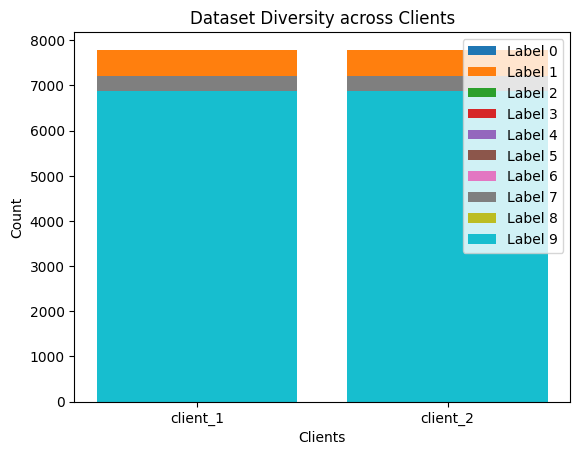

Training client_1...
Epoch 1/2, Loss: 2.2695, Accuracy: 23.75%
Epoch 2/2, Loss: 2.1183, Accuracy: 48.68%
Training complete.
Training client_2...
Epoch 1/2, Loss: 2.2696, Accuracy: 24.16%
Epoch 2/2, Loss: 2.1170, Accuracy: 48.61%
Training complete.
Client Performance for Round 1: {'client_1': {'accuracy': 0.5976792242886664, 'loss': 1.9926849330419092}, 'client_2': {'accuracy': 0.5959887870993844, 'loss': 1.9898312643803864}}
Global Round: 1, Global Model Accuracy: 59.79%

Starting Global Round 2...


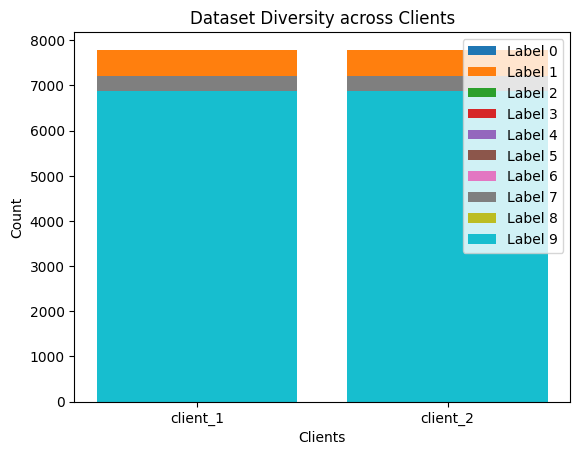

Training client_1...
Epoch 1/2, Loss: 1.9015, Accuracy: 57.34%
Epoch 2/2, Loss: 1.6632, Accuracy: 63.53%
Training complete.
Training client_2...
Epoch 1/2, Loss: 1.8979, Accuracy: 57.20%
Epoch 2/2, Loss: 1.6583, Accuracy: 63.86%
Training complete.
Client Performance for Round 2: {'client_1': {'accuracy': 0.7334865103105447, 'loss': 1.5003643246322815}, 'client_2': {'accuracy': 0.7376961535127012, 'loss': 1.4954909048767937}}
Global Round: 2, Global Model Accuracy: 73.31%

Starting Global Round 3...


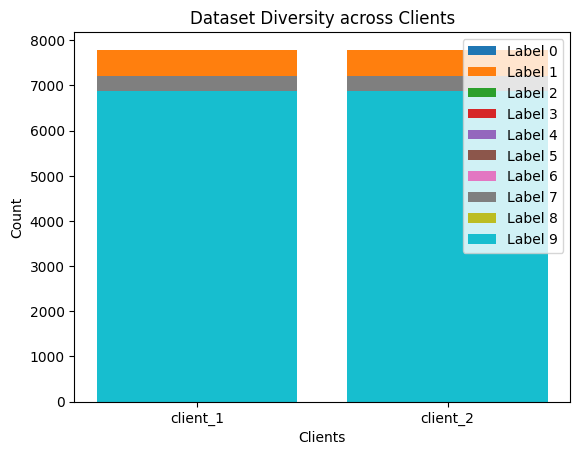

Training client_1...
Epoch 1/2, Loss: 1.4259, Accuracy: 67.94%
Epoch 2/2, Loss: 1.2285, Accuracy: 70.72%
Training complete.
Training client_2...
Epoch 1/2, Loss: 1.4256, Accuracy: 68.05%
Epoch 2/2, Loss: 1.2253, Accuracy: 70.86%
Training complete.
Client Performance for Round 3: {'client_1': {'accuracy': 0.7861013569168076, 'loss': 1.078501314696014}, 'client_2': {'accuracy': 0.7861312602953501, 'loss': 1.0757566802272513}}
Global Round: 3, Global Model Accuracy: 78.45%

Starting Global Round 4...


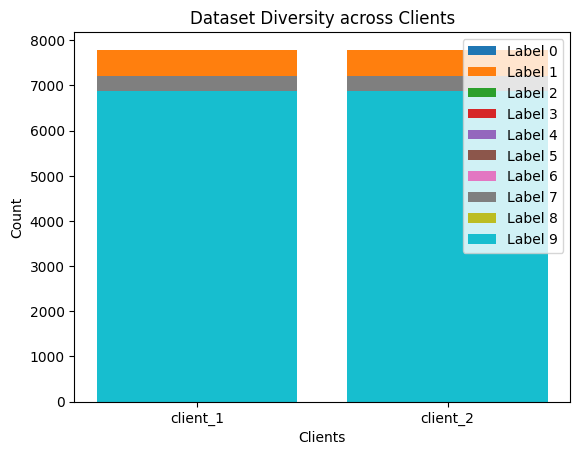

Training client_1...
Epoch 1/2, Loss: 1.0776, Accuracy: 72.38%
Epoch 2/2, Loss: 0.9612, Accuracy: 74.25%
Training complete.
Training client_2...
Epoch 1/2, Loss: 1.0724, Accuracy: 72.76%
Epoch 2/2, Loss: 0.9554, Accuracy: 74.56%
Training complete.
Client Performance for Round 4: {'client_1': {'accuracy': 0.8075605843846188, 'loss': 0.8291989234370798}, 'client_2': {'accuracy': 0.8117070774210329, 'loss': 0.8232926967624375}}
Global Round: 4, Global Model Accuracy: 80.80%

Starting Global Round 5...


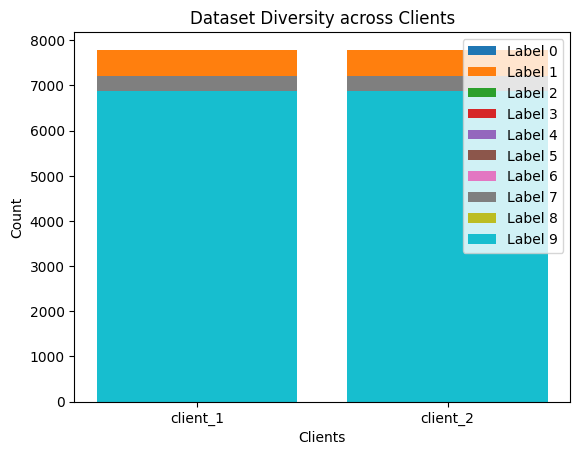

Training client_1...
Epoch 1/2, Loss: 0.8761, Accuracy: 75.46%
Epoch 2/2, Loss: 0.8092, Accuracy: 76.74%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.8718, Accuracy: 75.68%
Epoch 2/2, Loss: 0.8041, Accuracy: 76.96%
Training complete.
Client Performance for Round 5: {'client_1': {'accuracy': 0.8254360486120143, 'loss': 0.6898552667962425}, 'client_2': {'accuracy': 0.8298268936219403, 'loss': 0.6846465381368472}}
Global Round: 5, Global Model Accuracy: 82.59%

Starting Global Round 6...


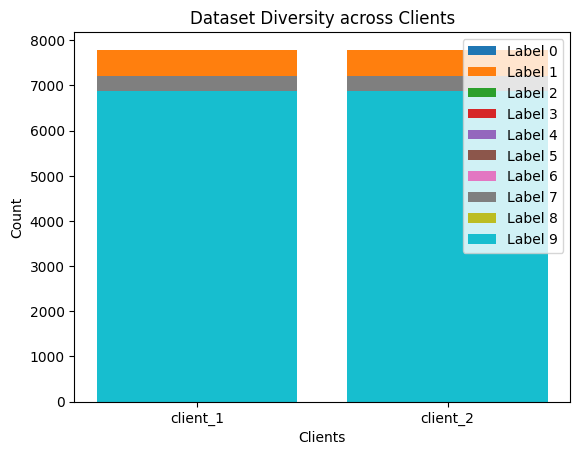

Training client_1...
Epoch 1/2, Loss: 0.7574, Accuracy: 77.94%
Epoch 2/2, Loss: 0.7177, Accuracy: 78.75%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.7549, Accuracy: 77.98%
Epoch 2/2, Loss: 0.7108, Accuracy: 78.94%
Training complete.
Client Performance for Round 6: {'client_1': {'accuracy': 0.8424733746622158, 'loss': 0.6056457301550123}, 'client_2': {'accuracy': 0.8450423373695922, 'loss': 0.6000686156496323}}
Global Round: 6, Global Model Accuracy: 84.22%

Starting Global Round 7...


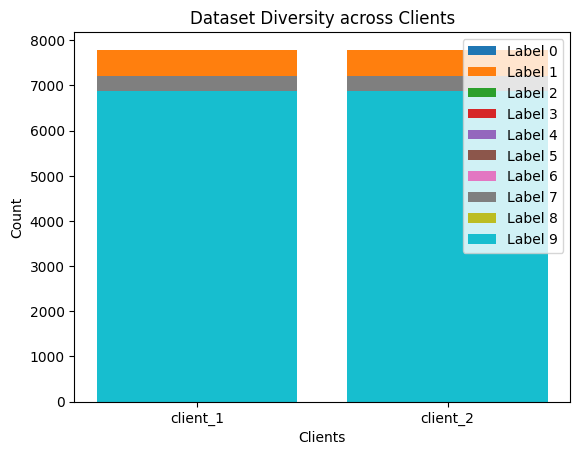

Training client_1...
Epoch 1/2, Loss: 0.6837, Accuracy: 79.51%
Epoch 2/2, Loss: 0.6557, Accuracy: 80.14%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.6811, Accuracy: 79.78%
Epoch 2/2, Loss: 0.6522, Accuracy: 80.42%
Training complete.
Client Performance for Round 7: {'client_1': {'accuracy': 0.853802690712562, 'loss': 0.5492818199662757}, 'client_2': {'accuracy': 0.8574545559633557, 'loss': 0.5441907743429301}}
Global Round: 7, Global Model Accuracy: 85.46%

Starting Global Round 8...


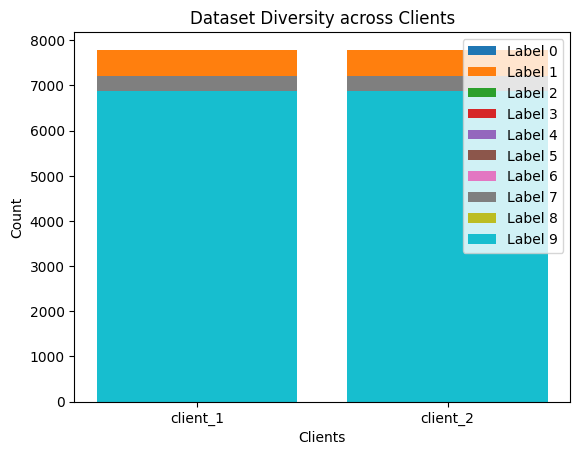

Training client_1...
Epoch 1/2, Loss: 0.6327, Accuracy: 80.91%
Epoch 2/2, Loss: 0.6133, Accuracy: 81.39%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.6263, Accuracy: 81.29%
Epoch 2/2, Loss: 0.6036, Accuracy: 81.99%
Training complete.
Client Performance for Round 8: {'client_1': {'accuracy': 0.8631667172439704, 'loss': 0.509180629677561}, 'client_2': {'accuracy': 0.8658497818108256, 'loss': 0.5036319831658203}}
Global Round: 8, Global Model Accuracy: 86.34%

Starting Global Round 9...


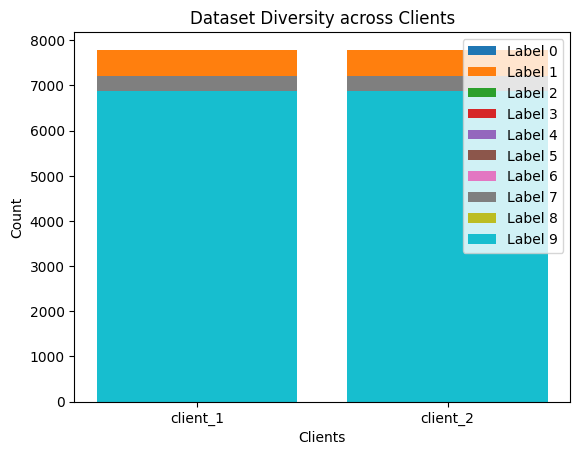

Training client_1...
Epoch 1/2, Loss: 0.5919, Accuracy: 82.18%
Epoch 2/2, Loss: 0.5735, Accuracy: 82.82%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.5848, Accuracy: 82.62%
Epoch 2/2, Loss: 0.5716, Accuracy: 83.09%
Training complete.
Client Performance for Round 9: {'client_1': {'accuracy': 0.8702330891172093, 'loss': 0.47785931946830257}, 'client_2': {'accuracy': 0.8734936277201398, 'loss': 0.4721921141949687}}
Global Round: 9, Global Model Accuracy: 87.03%

Starting Global Round 10...


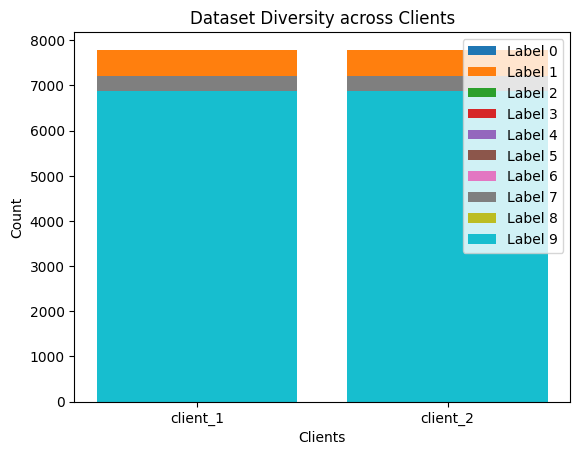

Training client_1...
Epoch 1/2, Loss: 0.5581, Accuracy: 83.14%
Epoch 2/2, Loss: 0.5461, Accuracy: 83.60%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.5558, Accuracy: 83.46%
Epoch 2/2, Loss: 0.5392, Accuracy: 83.98%
Training complete.
Client Performance for Round 10: {'client_1': {'accuracy': 0.8763746188638892, 'loss': 0.45264913236753335}, 'client_2': {'accuracy': 0.8790422795711355, 'loss': 0.44741423323392426}}
Global Round: 10, Global Model Accuracy: 87.64%

Starting Global Round 11...


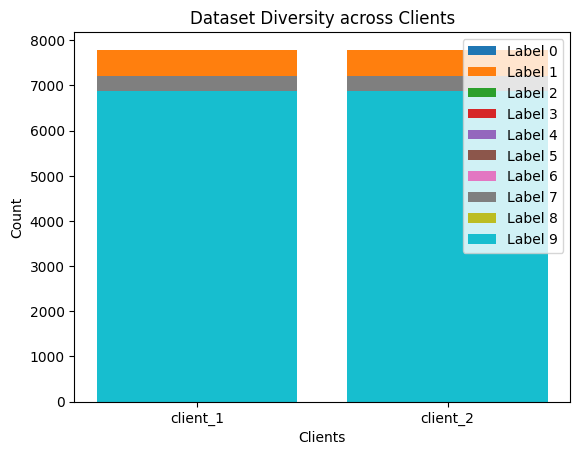

Training client_1...
Epoch 1/2, Loss: 0.5335, Accuracy: 84.10%
Epoch 2/2, Loss: 0.5217, Accuracy: 84.35%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.5279, Accuracy: 84.44%
Epoch 2/2, Loss: 0.5145, Accuracy: 84.84%
Training complete.
Client Performance for Round 11: {'client_1': {'accuracy': 0.8811433360789585, 'loss': 0.43218450726125246}, 'client_2': {'accuracy': 0.8839551483975377, 'loss': 0.4269038591802451}}
Global Round: 11, Global Model Accuracy: 88.11%

Starting Global Round 12...


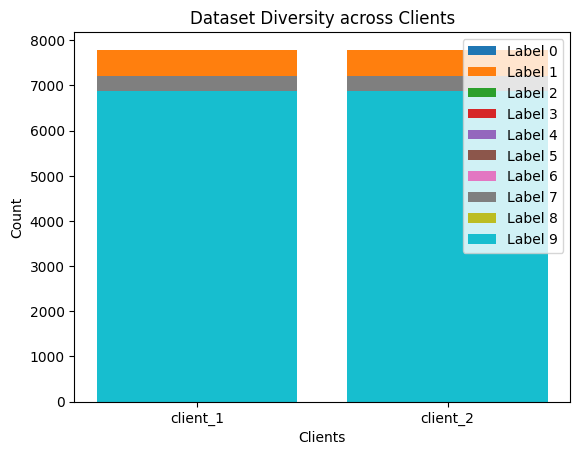

Training client_1...
Epoch 1/2, Loss: 0.5106, Accuracy: 84.77%
Epoch 2/2, Loss: 0.5015, Accuracy: 85.09%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.5056, Accuracy: 84.78%
Epoch 2/2, Loss: 0.4963, Accuracy: 85.31%
Training complete.
Client Performance for Round 12: {'client_1': {'accuracy': 0.8856085894712504, 'loss': 0.41472872035395414}, 'client_2': {'accuracy': 0.887712048088316, 'loss': 0.4096899492986321}}
Global Round: 12, Global Model Accuracy: 88.57%

Starting Global Round 13...


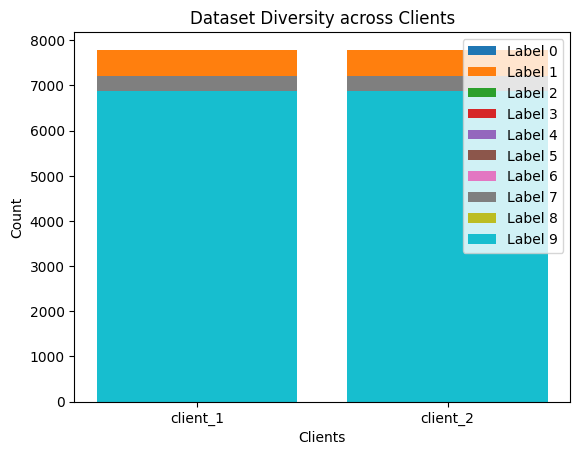

Training client_1...
Epoch 1/2, Loss: 0.4918, Accuracy: 85.37%
Epoch 2/2, Loss: 0.4824, Accuracy: 85.93%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4865, Accuracy: 85.61%
Epoch 2/2, Loss: 0.4803, Accuracy: 85.83%
Training complete.
Client Performance for Round 13: {'client_1': {'accuracy': 0.8883397638762446, 'loss': 0.40021872378596535}, 'client_2': {'accuracy': 0.8912666531803601, 'loss': 0.3952065062969097}}
Global Round: 13, Global Model Accuracy: 88.87%

Starting Global Round 14...


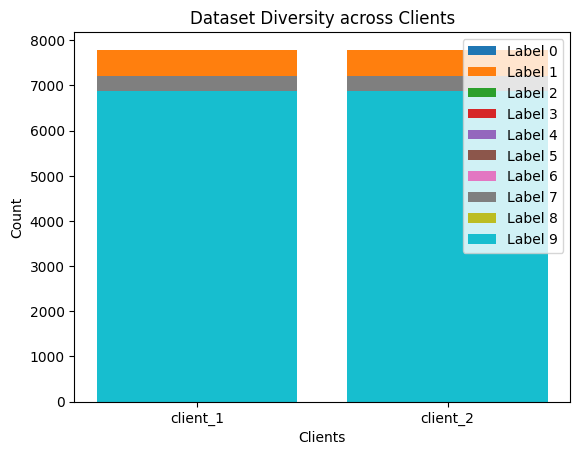

Training client_1...
Epoch 1/2, Loss: 0.4782, Accuracy: 85.78%
Epoch 2/2, Loss: 0.4683, Accuracy: 86.08%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4708, Accuracy: 86.04%
Epoch 2/2, Loss: 0.4644, Accuracy: 86.26%
Training complete.
Client Performance for Round 14: {'client_1': {'accuracy': 0.8915767113192006, 'loss': 0.3875235407690685}, 'client_2': {'accuracy': 0.8933473976244835, 'loss': 0.3825077923383157}}
Global Round: 14, Global Model Accuracy: 89.22%

Starting Global Round 15...


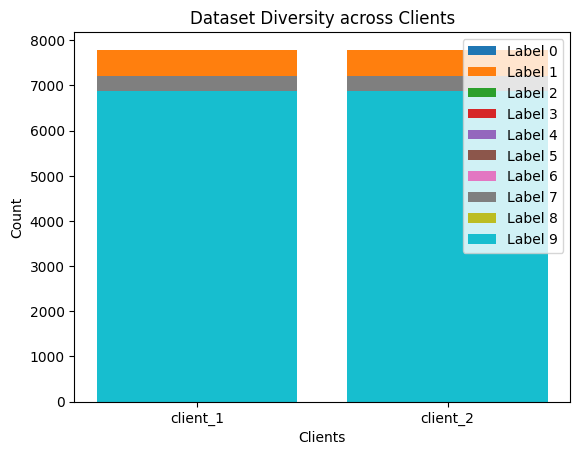

Training client_1...
Epoch 1/2, Loss: 0.4604, Accuracy: 86.43%
Epoch 2/2, Loss: 0.4530, Accuracy: 86.62%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4577, Accuracy: 86.47%
Epoch 2/2, Loss: 0.4507, Accuracy: 86.68%
Training complete.
Client Performance for Round 15: {'client_1': {'accuracy': 0.894134477825465, 'loss': 0.37601702755348076}, 'client_2': {'accuracy': 0.8966419096610121, 'loss': 0.37133480275184083}}
Global Round: 15, Global Model Accuracy: 89.49%

Starting Global Round 16...


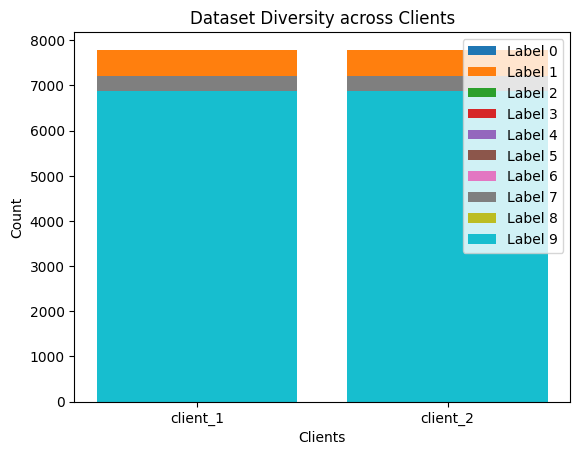

Training client_1...
Epoch 1/2, Loss: 0.4498, Accuracy: 86.65%
Epoch 2/2, Loss: 0.4428, Accuracy: 86.79%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4439, Accuracy: 86.99%
Epoch 2/2, Loss: 0.4379, Accuracy: 87.03%
Training complete.
Client Performance for Round 16: {'client_1': {'accuracy': 0.896475484458317, 'loss': 0.3660512173517354}, 'client_2': {'accuracy': 0.8981446695373233, 'loss': 0.3612486393278716}}
Global Round: 16, Global Model Accuracy: 89.66%

Starting Global Round 17...


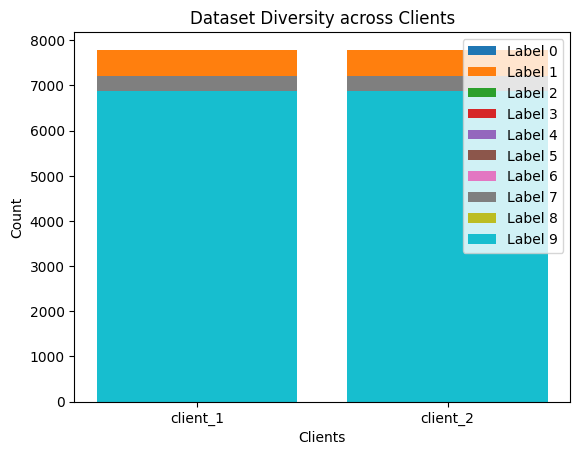

Training client_1...
Epoch 1/2, Loss: 0.4384, Accuracy: 86.93%
Epoch 2/2, Loss: 0.4318, Accuracy: 87.22%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4293, Accuracy: 87.40%
Epoch 2/2, Loss: 0.4253, Accuracy: 87.61%
Training complete.
Client Performance for Round 17: {'client_1': {'accuracy': 0.8987008858253493, 'loss': 0.3569487137599485}, 'client_2': {'accuracy': 0.9004421581943762, 'loss': 0.35196250409934526}}
Global Round: 17, Global Model Accuracy: 89.90%

Starting Global Round 18...


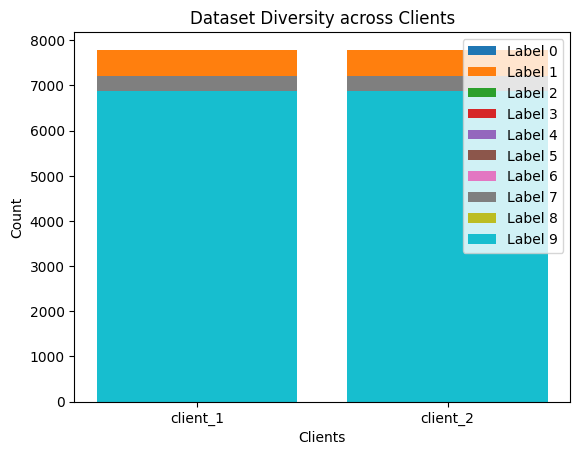

Training client_1...
Epoch 1/2, Loss: 0.4240, Accuracy: 87.49%
Epoch 2/2, Loss: 0.4224, Accuracy: 87.51%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4220, Accuracy: 87.52%
Epoch 2/2, Loss: 0.4154, Accuracy: 87.67%
Training complete.
Client Performance for Round 18: {'client_1': {'accuracy': 0.9009118365341541, 'loss': 0.34832075393849954}, 'client_2': {'accuracy': 0.9027540964656243, 'loss': 0.34343202688943}}
Global Round: 18, Global Model Accuracy: 90.04%

Starting Global Round 19...


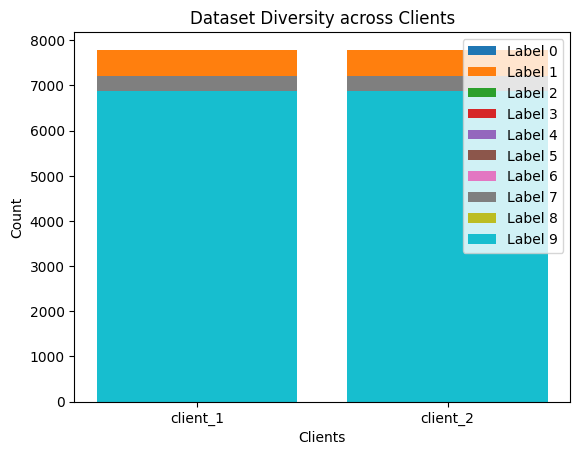

Training client_1...
Epoch 1/2, Loss: 0.4161, Accuracy: 87.71%
Epoch 2/2, Loss: 0.4126, Accuracy: 87.71%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4107, Accuracy: 87.92%
Epoch 2/2, Loss: 0.4074, Accuracy: 88.04%
Training complete.
Client Performance for Round 19: {'client_1': {'accuracy': 0.9030505339518216, 'loss': 0.34040993757807614}, 'client_2': {'accuracy': 0.9046614455394041, 'loss': 0.3356814615552395}}
Global Round: 19, Global Model Accuracy: 90.25%

Starting Global Round 20...


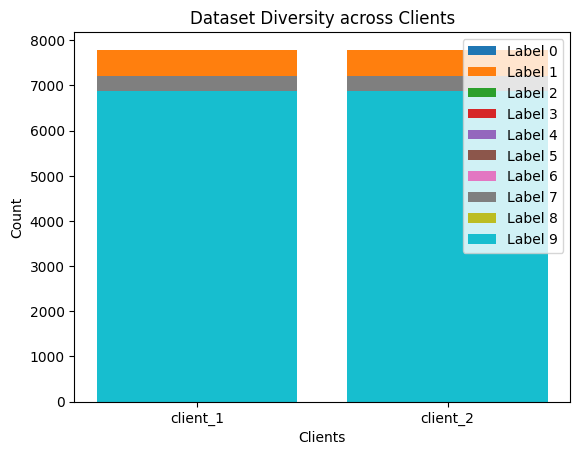

Training client_1...
Epoch 1/2, Loss: 0.4078, Accuracy: 87.93%
Epoch 2/2, Loss: 0.4038, Accuracy: 88.12%
Training complete.
Training client_2...
Epoch 1/2, Loss: 0.4029, Accuracy: 88.08%
Epoch 2/2, Loss: 0.3990, Accuracy: 88.20%
Training complete.
Client Performance for Round 20: {'client_1': {'accuracy': 0.9047990635973469, 'loss': 0.33311325173942086}, 'client_2': {'accuracy': 0.9066121434557697, 'loss': 0.3282812736694341}}
Global Round: 20, Global Model Accuracy: 90.37%


In [20]:

run = IID_simulation1(2, 20, 0.00001, loader_client1, loader_client2, test_loader)

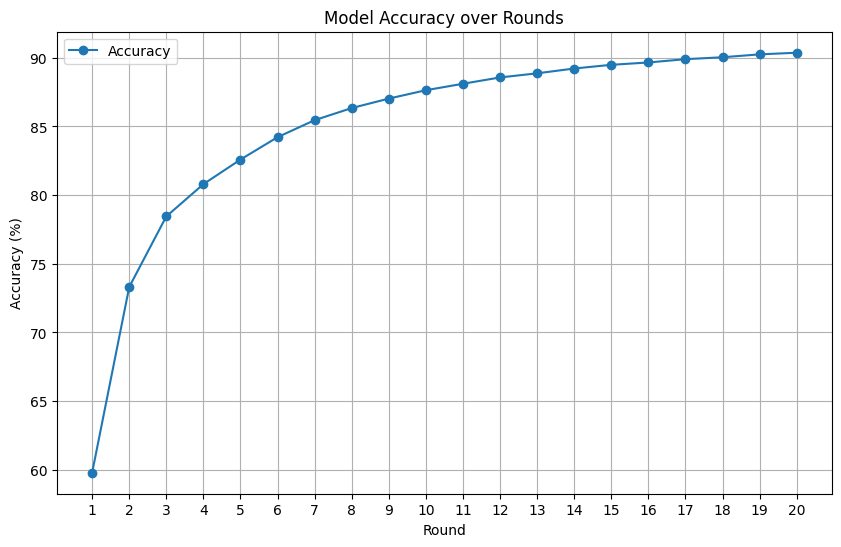

In [21]:
import matplotlib.pyplot as plt
import re

# Read accuracy values from the file
accuracies = []
with open('textfiles/accuracyiid_all.txt', 'r') as file:
    for line in file:
        # Use regex to find the numeric accuracy value (e.g., 17.83 from 'Round 1: 17.83%')
        match = re.search(r'(\d+\.\d+)%', line)
        if match:
            accuracies.append(float(match.group(1)))

# Generate x-axis (epochs or rounds)
epochs = range(1, len(accuracies) + 1)

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', label='Accuracy')
plt.title('Model Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)  # Show each epoch/round on the x-axis
plt.grid(True)
plt.legend()
plt.show()
